# Homework 4: Eric Miller

1) In your ThinkBayes2 repository, create a new notebook in the examples folder called homework4.ipynb.  You might want to start with template.ipynb.

 

2) Write solutions to the following problems

* Lecture 10: One more height problem

* Lecture 10: Lincoln index problem

* Lecture 11: The skeet problem

* Lecture 12: The social desirability problem

 

3) In addition, write a solution to one other problem that has appeared in the lecture notes.

 

4) Write a short description of 1-3 project ideas, with links to relevant resources.  Pitching an idea doesn't mean you are committed to work on it.

 

5) Add, commit, and push the new file.  Then view the notebook on GitHub and paste its URL below.

In [22]:
from thinkbayes2 import Suite, Pmf, Joint, MakeMixture, MakeJoint
import thinkplot

import numpy as np

## One more height problem

In a room of 10 randomly chosen U.S. residents, A is the second tallest.  How tall is A?  What is the probability that A is male?

In [3]:
from scipy.stats import norm

dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

hs = np.linspace(130, 210)
ps = dist_height['male'].pdf(hs)
male_height_pmf = Pmf(dict(zip(hs, ps)));

ps = dist_height['female'].pdf(hs)
female_height_pmf = Pmf(dict(zip(hs, ps)));

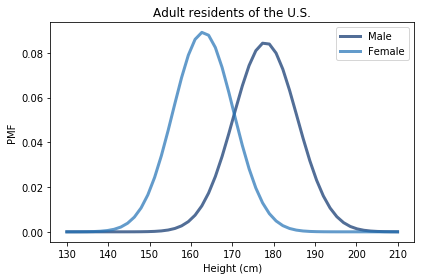

In [4]:
thinkplot.Pdf(male_height_pmf, label='Male')
thinkplot.Pdf(female_height_pmf, label='Female')

thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Adult residents of the U.S.')

In [16]:
male_tagged_heights = Joint({('male', height): p
                             for height, p in male_height_pmf.Items()})

female_tagged_heights = Joint({('female', height): p
                             for height, p in female_height_pmf.Items()})

metapmf = Pmf({male_tagged_heights : 0.49,
              female_tagged_heights: 0.51})

tagged_heights = Joint(MakeMixture(metapmf))

In [17]:
tagged_heights.Marginal(0)

Pmf({'male': 0.49000000000000016, 'female': 0.5100000000000001})

In [21]:
class HeightCompare(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        hypo is person A (gender, height), person B (gender, height))
        data is str "A" or "B" i.e. "person X is greater"
        """
        (_, A), (_, B) = hypo
        who = data
        
        taller = A if who == 'A' else B
        shorter = B if who == 'A' else A
        
        return float(taller > shorter)

Mean height 182.2567301052373cm


Pmf({'male': 0.930478884502192, 'female': 0.06952111549780843})

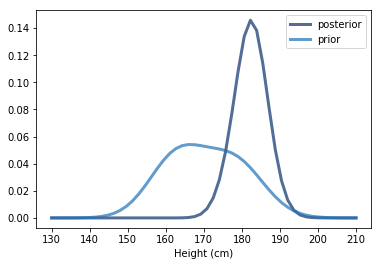

In [34]:
person = tagged_heights.Copy()
for winner in 'AAAAAAAAAB':
    comparison = HeightCompare(MakeJoint(person, tagged_heights))
    comparison.Update(winner)
    person = Joint(comparison.Marginal(0))
    
thinkplot.Pdf(person.Marginal(1), label='posterior')
thinkplot.Pdf(tagged_heights.Marginal(1), label='prior')
thinkplot.Config(xlabel="Height (cm)")

print(f"Mean height {person.Marginal(1).Mean()}cm")
person.Marginal(0)

## Lincoln index

Read How many errors are left to find?, and write a Bayesian solution to this problem:

*Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  [I changed Cook's notation to be consistent with mine].*

For concreteness, suppose the first tester finds 20 bugs, the second finds 15, and they find 3 in common.

Compare your solution to the Lincoln Index, which estimates the total number of errors as k1 k2 / c.

In [68]:
# Based on Bear Population solution
from scipy.special import factorial
from thinkbayes2 import EvalBinomialPmf

class Bugs(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: tuple of (num_A, num_B, overlap) where A and B are the testers
        hypo: number of bugs
        """
        bugs = hypo
        num_A, num_B, overlap = data
        
        if bugs < num_A or bugs < num_B:
            return 0
        
        # Goodness of each tester
        p_A = num_A / bugs
        p_B = num_B / bugs
        p_both = p_A * p_B
                
        return EvalBinomialPmf(overlap, bugs, p_both)

Bayesian answer: 200.0988046930462
Lincoln answer: 100.0


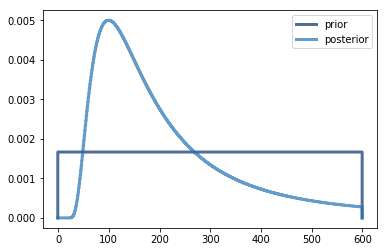

In [79]:
# Using a flat prior
prior = Bugs(range(600))

posterior = prior.Copy()
posterior.Update((20, 15, 3))

thinkplot.Pmf(prior, label='prior')
thinkplot.Pmf(posterior, label='posterior')
thinkplot.Config()

print(f'Bayesian answer: {posterior.Mean()}')
print(f'Lincoln answer: {20*15/3}')

**Solution Notes** This solution takes the approach of estimating the number of bugs directly, without also explicitly estimating a distribution for the bug-catching-effectiveness of each tester.
It would be reasonable to instead perform a 3-way joint optimization, especially if you had the same testers looking at many codebases.

The selection of prior also deserves some more love, but I am not sure what an appropriate distribution is that is defined over only nonnegative integers, given the information in the problem.

## Skeets

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

In [81]:
from thinkbayes2 import EvalBinomialPmf

class Shooter(Suite):
    def Likelihood(self, data, hypo):
        p_hit = hypo
        n_hits, n_shots = data
        
        return EvalBinomialPmf(n_hits, n_shots, p_hit)

In [85]:
%psource Beta

Kim is better with p=0.592058672742687


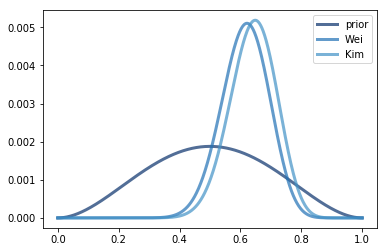

In [120]:
from thinkbayes2 import Beta, MakeBinomialPmf

prior = Shooter(Beta(3,3).MakePmf(1000))

kim = prior.Copy()
wei = prior.Copy()

def updateBoth(hits, shots):
    kim.Update((hits, shots))
    wei.Update((hits, shots))

updateBoth(15, 25)
updateBoth(1, 2)
updateBoth(2, 2)
updateBoth(2, 2)

wei.Update((1,2))
kim.Update((2,2))

kim_better = (kim - wei).ProbGreater(0)

thinkplot.Pdf(prior, label='prior')
thinkplot.Pdf(wei, label='Wei')
thinkplot.Pdf(kim, label='Kim')
thinkplot.Config()

print(f"Kim is better with p={kim_better}")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


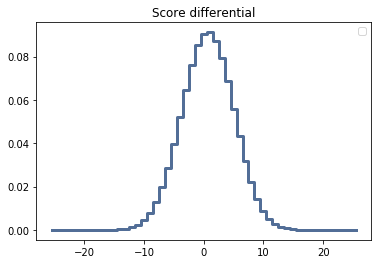

Probability of Kim winning a rematch: 0.5617843799000362


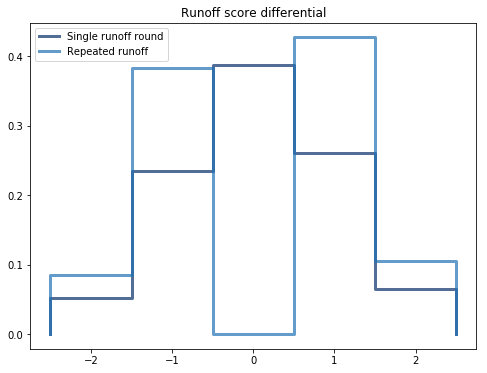

In [121]:
def expected_shots(shooter, shots=25):
    metapmf = Pmf({MakeBinomialPmf(shots, skill): p for skill, p in shooter.Items()})
    mix = MakeMixture(metapmf)
    return mix

main = expected_shots(kim)-expected_shots(wei)

thinkplot.Pmf(main)
thinkplot.Config(title='Score differential')
thinkplot.Show()

runoff = expected_shots(kim, 2) - expected_shots(wei, 2)

thinkplot.Pmf(runoff, label='Single runoff round')

runoff[0] = 0
runoff.Normalize()

thinkplot.Pmf(runoff, label='Repeated runoff')
thinkplot.Config(title='Runoff score differential')

print(f"Probability of Kim winning a rematch: {main.ProbGreater(0) + main[0] * runoff.ProbGreater(0)}")

## Social desirability

Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to shade their answers in the direction they think shows them in the most positive light.

One of the ways to improve the quality of the results is to collect responses in indirect ways.  For example, here's a clever way one research group estimated the prevalence of atheists.

Another way is "randomized response", as described in this article or this video (if you can stand it).

As an example, suppose you ask 100 people to flip a coin and:

If they get heads, they report YES.
If they get tails, then honestly answer the question "Do you believe in God?"

And suppose you get 80 YESes and 20 NOs.

Estimate the prevalence of atheists in the surveyed population (by which, as always, I mean compute a posterior distribution).

In [123]:
from thinkbayes2 import EvalBinomialPmf

class Atheists(Suite, Joint):
    def Likelihood(self, data, hypo):
        n_yes = data
        n_heads, p_atheist = hypo
        
        return EvalBinomialPmf(n_yes - n_heads, 100 - n_heads, p_atheist)

Posterior mean: 58.40938722151472% atheist


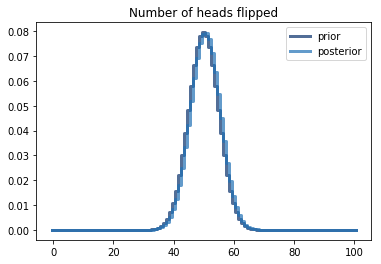

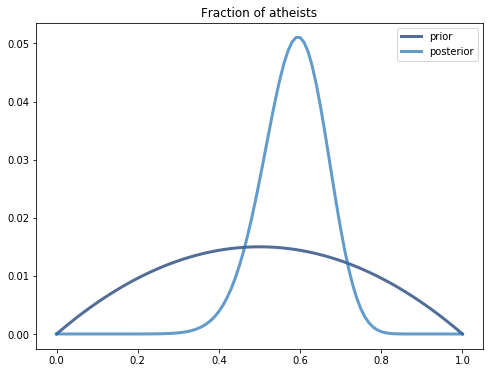

<Figure size 576x432 with 0 Axes>

In [137]:
from thinkbayes2 import MakeBinomialPmf, Beta, MakeJoint

prior_heads = MakeBinomialPmf(100, 0.5)
prior_atheists = Beta(2,2).MakePmf()

prior = Atheists(MakeJoint(prior_heads, prior_atheists))

posterior = prior.Copy()

posterior.Update(80)

print(f"Posterior mean: {100 * posterior.Marginal(1).Mean()}% atheist")

thinkplot.Pmf(prior.Marginal(0), label='prior')
thinkplot.Pmf(posterior.Marginal(0), label='posterior')
thinkplot.Config(title='Number of heads flipped')
thinkplot.Show()

thinkplot.Pdf(prior.Marginal(1), label='prior')
thinkplot.Pdf(posterior.Marginal(1), label='posterior')
thinkplot.Config(title='Fraction of atheists')
thinkplot.Show()

# The volunteer problem

This comes from a participant at a Bayesian workshop I ran years ago:

"A group of people sign up to do a community service project.  Some fraction of them actually participate, and then some fraction of the participants report back to confirm.  In other words, some of the people who sign up don't participate, and some of the people that participate don't report back.

Given the number of people who sign up and the number of people who report back, can we estimate the number of people who actually participated?"

One way to model this scenario is to say that each person who signs up has a probability, q, of participating and a probability, r, of reporting back.  (Let's assume that if someone does not participate, they don't report that they did.) 

Suppose 140 people sign up and only 50 report back.  With this data we can compute posterior distributions for q and r, but we can't distinguish between them.

But suppose we call 5 people who signed up and learn that 3 of them participated and 1 reported back.  How can we combine the data from these two sources to estimate the distributions of q and r?

And how do we use those distributions to estimate the number of people who participated?



In [146]:
from thinkbayes2 import EvalBinomialPmf

class SingleVar(Suite):
    def Likelihood(self, data, hypo):
        rate = hypo
        n_did, n_attempts = data
        
        return EvalBinomialPmf(n_did, n_attempts, rate)
    
class DualVar(Suite, Joint):
    def Likelihood(self, data, hypo):
        q, r = hypo
        num_reports, num_signups = data
        
        return EvalBinomialPmf(num_reports, num_signups, q*r)

In [147]:
q_prior = Beta(2,2).MakePmf()
r_prior = Beta(2,2).MakePmf()

Mean number of participants: 89.14372698457613


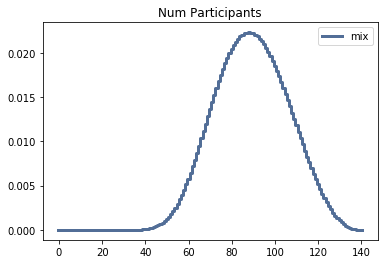

<Figure size 576x432 with 0 Axes>

In [158]:
q = SingleVar(q_prior)
r = SingleVar(r_prior)

q.Update((3,5))
r.Update((1,3))

posterior = DualVar(MakeJoint(q, r))

posterior.Update((50, 140))

q_post = posterior.Marginal(0)
metapmf = Pmf({MakeBinomialPmf(140, q): p for q, p in q_post.Items()})
mix = MakeMixture(metapmf)

print(f"Mean number of participants: {mix.Mean()}")

thinkplot.Pmf(mix)
thinkplot.Config(title="Num Participants")
thinkplot.Show()

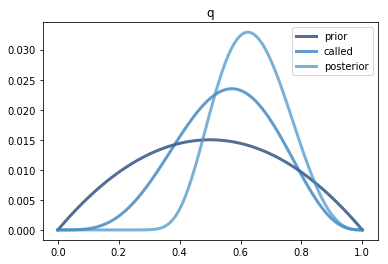

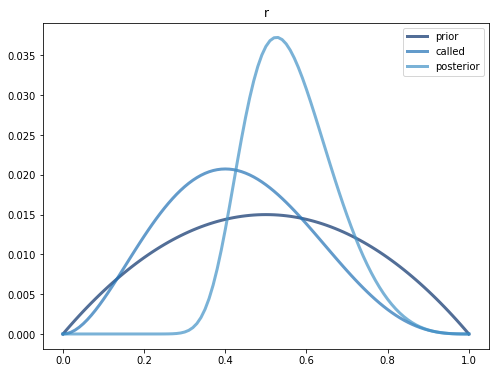

<Figure size 576x432 with 0 Axes>

In [157]:
thinkplot.Pdf(q_prior, label='prior')
thinkplot.Pdf(q, label='called')
thinkplot.Pdf(posterior.Marginal(0), label='posterior')
thinkplot.Config(title='q')
thinkplot.Show()

thinkplot.Pdf(r_prior, label='prior')
thinkplot.Pdf(r, label='called')
thinkplot.Pdf(posterior.Marginal(1), label='posterior')
thinkplot.Config(title='r')
thinkplot.Show()

# Project proposals

## Non-greedy battleship
The battleship problem as presented suggests a greedy algorithm for selecting the next move to play. How can we use bayesian methods to generate (or at least assess) non-greedy algorithms? There might be better games than Battleship to do this with, but I would be interested in further exploring decision theory based on Bayesian estimation.

## Expo Judging

[This](https://www.anishathalye.com/2015/03/07/designing-a-better-judging-system/)
 and [This](https://www.anishathalye.com/2015/11/09/implementing-a-scalable-judging-system/)
 article propose an algorithm for taking a large number of pairwise comparison judgements and converting them into a single global ranking of teams at a hackathon. Their approach is already vaguely Bayesian, but limited by the graph algorithms they needed to use. Can we use MCMC or other explicitly-Bayesian techniques to allow more general parameterization of both teams and judges to provide better results?